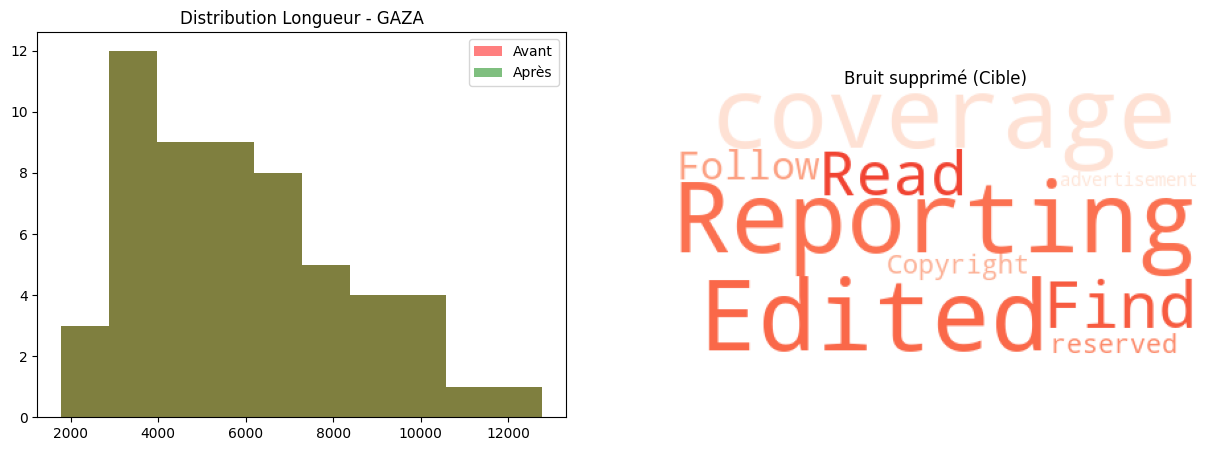

✅ GAZA terminé. Fichier enregistré dans : corpus/corpus_gaza_nettoye_v1.json
   Moyenne de bruit supprimé : 5.21 caractères par article.



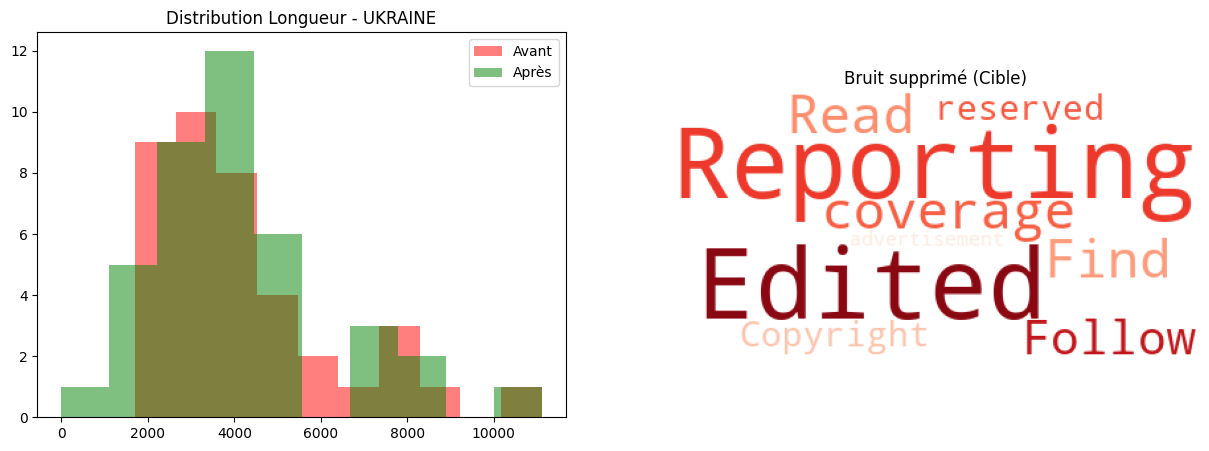

✅ UKRAINE terminé. Fichier enregistré dans : corpus/corpus_ukraine_nettoye_v1.json
   Moyenne de bruit supprimé : 81.64 caractères par article.



In [2]:
import json
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Création du dossier si besoin
if not os.path.exists('corpus'):
    os.makedirs('corpus')

def nettoyage_initial(text):
    if not text: return ""
    # 1. Enlever les sauts de ligne et espaces multiples
    text = text.replace('\\n', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    
    # 2. Suppression du "bruit" (signatures et pubs)
    # On ne touche PAS aux noms de pays ou aux acteurs de la guerre
    patterns_bruit = [
        r'Reporting by.*', r'Edited by.*', r'Find more of .* coverage at.*',
        r'Read more:.*', r'Follow us on.*', r'©.*', r'All rights reserved.*',
        r'Senior foreign affairs correspondent .* discusses.*'
    ]
    for pattern in patterns_bruit:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
        
    # 3. Normalisation (guillemets)
    text = text.replace('“', '"').replace('”', '"').replace('’', "'").replace('‘', "'")
    return text.strip()

def executer_pipeline_nettoyage(nom_conflit, input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        articles = json.load(f)
    
    stats = []
    for art in articles:
        avant = art['content']
        apres = nettoyage_initial(avant)
        
        stats.append({
            'len_avant': len(avant),
            'len_apres': len(apres),
            'bruit_elimine': len(avant) - len(apres)
        })
        # On remplace le contenu par la version propre
        art['content'] = apres

    # Sauvegarde
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(articles, f, indent=4, ensure_ascii=False)
    
    df = pd.DataFrame(stats)
    
    # --- VISUALISATIONS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Histogramme
    ax1.hist(df['len_avant'], alpha=0.5, label='Avant', color='red')
    ax1.hist(df['len_apres'], alpha=0.5, label='Après', color='green')
    ax1.set_title(f'Distribution Longueur - {nom_conflit}')
    ax1.legend()

    # 2. WordCloud du Bruit (Mots que nous voulons éliminer)
    mots_bruit = "Reporting Edited coverage Find Read Follow Copyright reserved advertisement"
    wc = WordCloud(background_color='white', colormap='Reds').generate(mots_bruit)
    ax2.imshow(wc)
    ax2.set_title(f'Bruit supprimé (Cible)')
    ax2.axis('off')
    
    plt.show()
    
    print(f"✅ {nom_conflit} terminé. Fichier enregistré dans : {output_file}")
    print(f"   Moyenne de bruit supprimé : {df['bruit_elimine'].mean():.2f} caractères par article.\n")

# --- LANCEMENT POUR LES DEUX ---
executer_pipeline_nettoyage("GAZA", 'corpus/corpus_gaza_v1.json', 'corpus/corpus_gaza_nettoye_v1.json')
executer_pipeline_nettoyage("UKRAINE", 'corpus/corpus_ukraine_v1.json', 'corpus/corpus_ukraine_nettoye_v1.json')

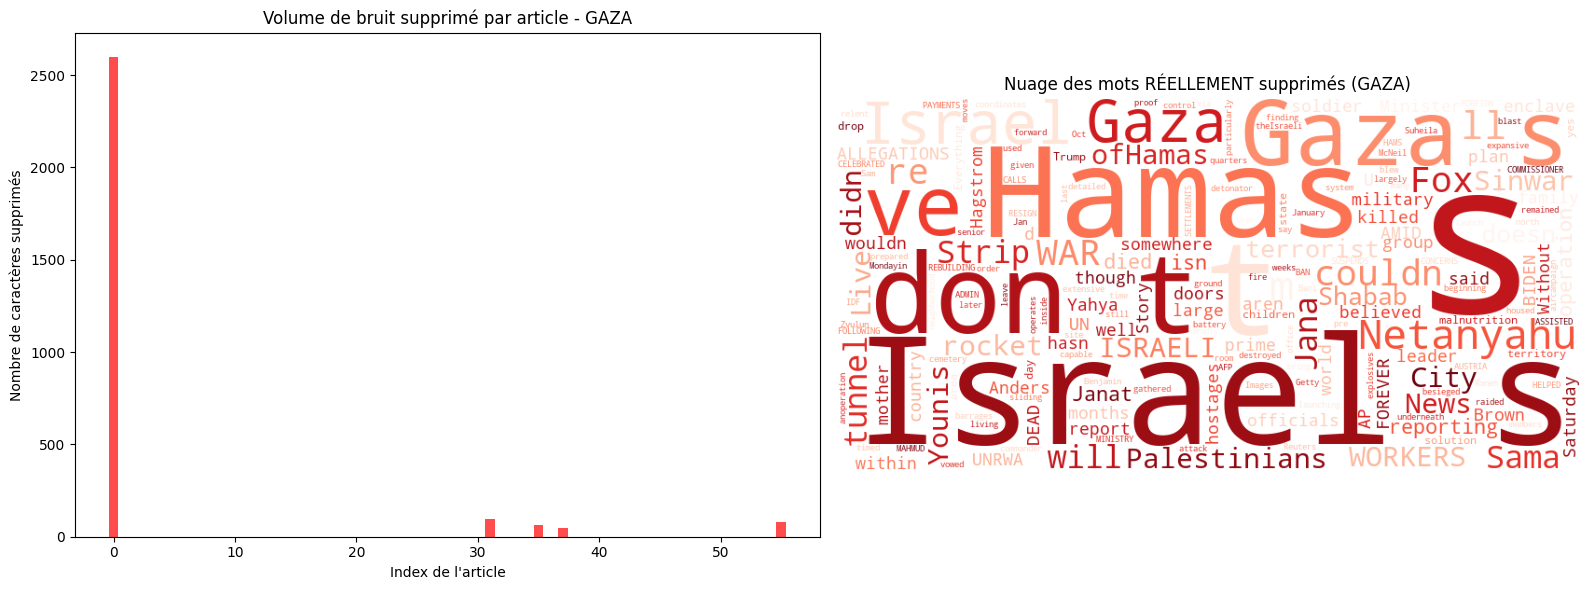

✅ Analyse GAZA terminée. Moyenne supprimée : 51.6 caractères.


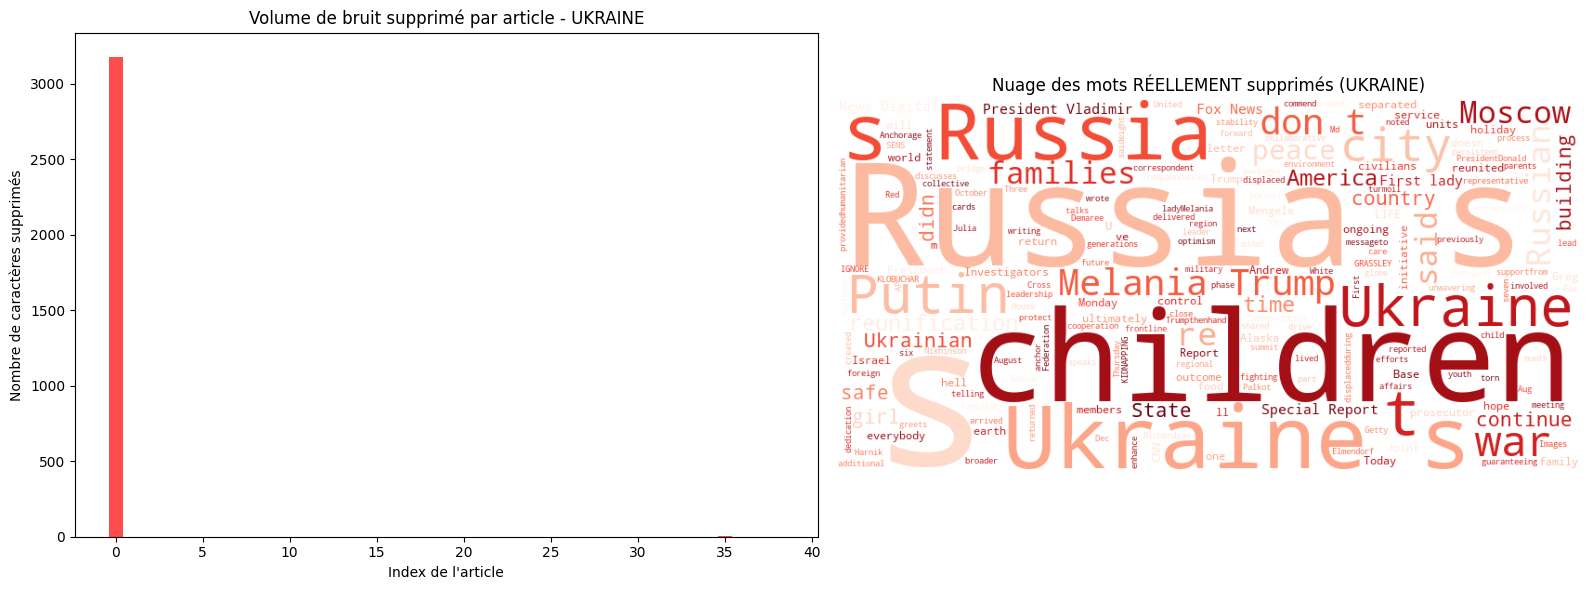

✅ Analyse UKRAINE terminée. Moyenne supprimée : 81.6 caractères.


In [3]:
import json
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def nettoyage_initial_extract(text):
    if not text: return "", ""
    original = text
    # Nettoyage
    processed = text.replace('\\n', ' ').replace('\n', ' ')
    processed = re.sub(r'\s+', ' ', processed)
    
    patterns_bruit = [
        r'Reporting by.*', r'Edited by.*', r'Find more of .* coverage at.*',
        r'Read more:.*', r'Follow us on.*', r'©.*', r'All rights reserved.*',
        r'Senior foreign affairs correspondent .* discusses.*',
        r'AUSTRIA SUSPENDS PAYMENTS TO UNRWA.*'
    ]
    
    for pattern in patterns_bruit:
        processed = re.sub(pattern, '', processed, flags=re.IGNORECASE)
    
    processed = processed.replace('“', '"').replace('”', '"').replace('’', "'").replace('‘', "'").strip()
    
    # EXTRACTION DU BRUIT RÉEL : on compare ce qui a disparu
    # On simplifie en prenant les bouts de phrases qui ne sont plus dans le texte final
    bruit_reel = original
    if processed:
        # On ne garde que les mots qui étaient là au début mais plus à la fin
        mots_originaux = original.split()
        mots_finaux = processed.split()
        bruit_reel = " ".join([m for m in mots_originaux if m not in mots_finaux])

    return processed, bruit_reel

def executer_pipeline_visualisation(nom_conflit, input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        articles = json.load(f)
    
    stats = []
    texte_bruit_cumule = ""
    
    for art in articles:
        avant = art['content']
        apres, bruit = nettoyage_initial_extract(avant)
        
        diff = len(avant) - len(apres)
        stats.append({'id': art.get('url', 'art')[:15], 'bruit_taille': diff})
        texte_bruit_cumule += " " + bruit
        art['content'] = apres

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(articles, f, indent=4, ensure_ascii=False)
    
    df = pd.DataFrame(stats)

    # --- VISUALISATIONS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Graphique du bruit supprimé (On voit enfin la différence !)
    ax1.bar(range(len(df)), df['bruit_taille'], color='red', alpha=0.7)
    ax1.set_title(f'Volume de bruit supprimé par article - {nom_conflit}')
    ax1.set_ylabel('Nombre de caractères supprimés')
    ax1.set_xlabel('Index de l\'article')

    # 2. WordCloud du BRUIT RÉEL (ce qui a été vraiment enlevé)
    if len(texte_bruit_cumule.strip()) > 0:
        wc = WordCloud(background_color='white', colormap='Reds', width=800, height=400).generate(texte_bruit_cumule)
        ax2.imshow(wc)
    ax2.set_title(f'Nuage des mots RÉELLEMENT supprimés ({nom_conflit})')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"✅ Analyse {nom_conflit} terminée. Moyenne supprimée : {df['bruit_taille'].mean():.1f} caractères.")

# Lancer pour Gaza et Ukraine
executer_pipeline_visualisation("GAZA", 'corpus/corpus_gaza_v1.json', 'corpus/corpus_palestine_nettoye_v1.json')
executer_pipeline_visualisation("UKRAINE", 'corpus/corpus_ukraine_v1.json', 'corpus/corpus_ukraine_nettoye_v1.json')


Traitement de GAZA...


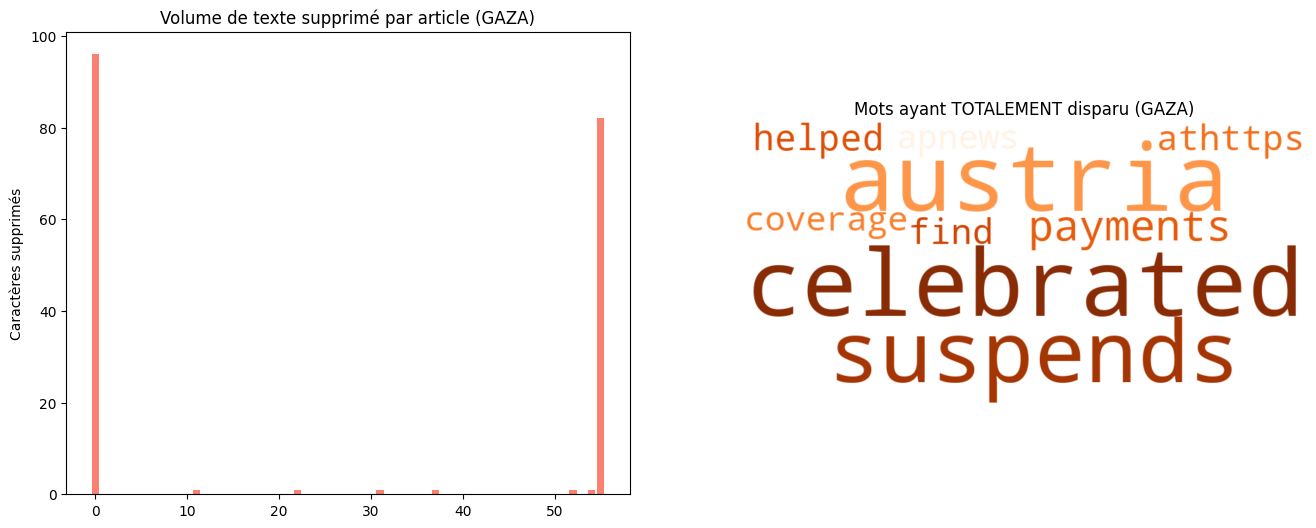

✅ Terminé : GAZA. Moyenne de suppression : 3.3 chars.

Traitement de UKRAINE...


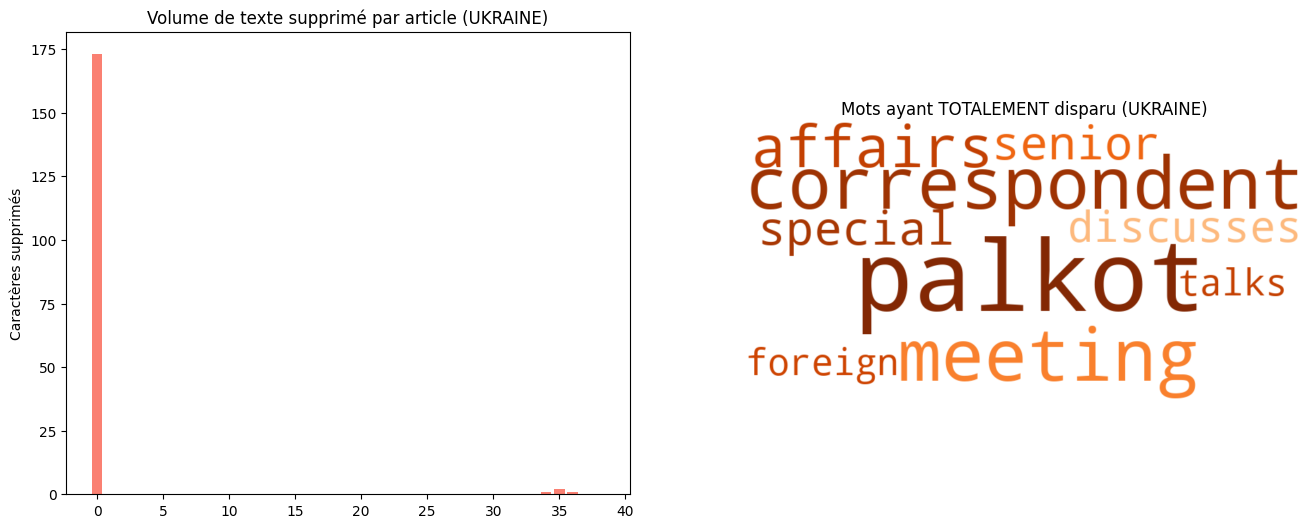

✅ Terminé : UKRAINE. Moyenne de suppression : 4.5 chars.


In [4]:
import json
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# 1. Configuration des dossiers
os.makedirs('corpus', exist_ok=True)
os.makedirs('images', exist_ok=True)

def nettoyage_initial(text):
    if not text: return ""
    # Nettoyage de base
    text = text.replace('\\n', '\n')
    
    # Patterns de bruit (signatures, pubs, réseaux sociaux): on cherche le bruit en début ou fin de ligne uniquement
    # On utilise ^ (début)
    patterns_bruit = [
        r'^Senior foreign affairs correspondent.*?\.', # S'arrête au premier point
        r'Reporting by.*?\n',                          # S'arrête au premier saut de ligne
        r'Edited by.*?\n',
        r'Find more of .*? coverage at.*',
        r'AUSTRIA SUSPENDS PAYMENTS TO UNRWA.*?\n',
        r'©.*', 
        r'All rights reserved.*'
    ]
    for pattern in patterns_bruit:
        # flags=re.MULTILINE permet de traiter chaque ligne séparément
        text = re.sub(pattern, '', text, flags=re.IGNORECASE| re.MULTILINE)
    
    # Normalisation ponctuation
    text = text.replace('“', '"').replace('”', '"').replace('’', "'").replace('‘', "'")
    # Nettoyage final des espaces
    text = text.replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def executer_pipeline_expert(nom_label, fichier_in, fichier_out):
    print(f"\nTraitement de {nom_label}...")
    with open(fichier_in, 'r', encoding='utf-8') as f:
        articles = json.load(f)

    mots_supprimes_total = []
    stats = []

    for art in articles:
        avant = art['content']
        apres = nettoyage_initial(avant)
        
        # LOGIQUE DE SÉCURITÉ : 
        # On identifie les mots qui étaient dans 'avant' mais qui ne sont PLUS DU TOUT dans 'apres'
        set_avant = set(re.findall(r'\w+', avant.lower()))
        set_apres = set(re.findall(r'\w+', apres.lower()))
        mots_perdus = set_avant - set_apres
        
        # On ne garde que les vrais bruits (on ignore les mots très courts de 1 ou 2 lettres)
        mots_perdus = [m for m in mots_perdus if len(m) > 3]
        mots_supprimes_total.extend(mots_perdus)
        
        stats.append({
            'len_diff': len(avant) - len(apres),
            'mots_perdus_count': len(mots_perdus)
        })
        art['content'] = apres # Mise à jour

    # Sauvegarde du JSON
    with open(fichier_out, 'w', encoding='utf-8') as f:
        json.dump(articles, f, indent=4, ensure_ascii=False)

    df = pd.DataFrame(stats)

    # --- VISUALISATIONS ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Graphique 1 : Volume de caractères jetés à la poubelle
    ax1.bar(range(len(df)), df['len_diff'], color='salmon')
    ax1.set_title(f'Volume de texte supprimé par article ({nom_label})')
    ax1.set_ylabel('Caractères supprimés')

    # Graphique 2 : WordCloud des mots DÉFINITIVEMENT supprimés
    if mots_supprimes_total:
        # On calcule la fréquence réelle de ces mots perdus
        frequence_bruit = Counter(mots_supprimes_total)
        wc = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(frequence_bruit)
        ax2.imshow(wc, interpolation='bilinear')
        ax2.set_title(f'Mots ayant TOTALEMENT disparu ({nom_label})')
    ax2.axis('off')

    plt.savefig(f'images/verif_nettoyage_{nom_label.lower()}.png')
    plt.show()
    
    print(f"✅ Terminé : {nom_label}. Moyenne de suppression : {df['len_diff'].mean():.1f} chars.")

# --- LANCEMENT ---
executer_pipeline_expert("GAZA", 'corpus/corpus_gaza_v1.json', 'corpus/corpus_gaza_nettoye_v1.json')
executer_pipeline_expert("UKRAINE", 'corpus/corpus_ukraine_v1.json', 'corpus/corpus_ukraine_nettoye_v1.json')

netoiyage :
- double 